# C-MTEB检索任务评测对比

本notebook用于评测两个模型在C-MTEB检索任务上的性能：
1. **BGE-M3** (`./bge-m3`)
2. **BGE-Reranker-M3-Finetuned** (`./final_model`)

我们将对这两个模型进行C-MTEB检索任务的评测，并可视化对比结果。

**注意**: 为了节省显存，我们将依次评测每个模型，评测完成后会清理显存。

## 0. 安装依赖

In [1]:
%pip install FlagEmbedding mteb sentence-transformers pandas matplotlib seaborn numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


### 安装必要的Python包

安装评测所需的依赖包：
- FlagEmbedding: 用于BGE模型
- mteb: 多语言文本嵌入评测工具
- sentence-transformers: 句子转换器库
- pandas, matplotlib, seaborn: 数据处理和可视化

## 1. 导入库

### 导入所需的Python库

导入数据处理、模型加载、评测和可视化所需的库，并设置中文显示和随机种子。

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import mteb
from mteb import MTEB
from sentence_transformers import SentenceTransformer
import torch
import gc

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

/home/xiaoke/miniconda3/envs/train_code_embedding/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 定义模型路径和配置

设置待评测模型的路径和配置信息，包括：
- 原始BGE-M3模型路径
- 微调后的BGE-M3模型路径
- 输出结果目录

## 2. 定义模型路径和配置

### 定义检索任务列表

选择要进行评测的C-MTEB检索任务，目前只使用T2Retrieval任务进行评测。

In [3]:
# 定义模型路径
BGE_M3_PATH = "./bge-m3"
BGE_M3_FINETUNE_PATH = "./models/bge-m3-finetuned/final_model"

# 定义输出目录
OUTPUT_DIR = "./c_mteb_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 定义模型配置
MODEL_CONFIGS = [
    {
        'name': 'BGE-M3',
        'path': BGE_M3_PATH,
        'description': '原始BGE-M3模型'
    },
    {
        'name': 'BGE-M3-Finetuned',
        'path': BGE_M3_FINETUNE_PATH,
        'description': '微调后的BGE-M3模型'
    }
]

print(f"BGE-M3路径: {BGE_M3_PATH}")
print(f"BGE_M3_FINETUNE_PATH路径: {BGE_M3_FINETUNE_PATH}")
print(f"输出目录: {OUTPUT_DIR}")

BGE-M3路径: ./bge-m3
BGE_M3_FINETUNE_PATH路径: ./models/bge-m3-finetuned/final_model
输出目录: ./c_mteb_results


### 显存管理函数

定义两个关键函数：
1. cleanup_memory(): 清理GPU显存和系统内存
2. load_and_evaluate_model(): 加载模型并执行评测任务

## 3. 定义检索任务

### 依次评测模型

按顺序评测两个模型，每次评测后清理显存以避免内存溢出，最后显示评测结果摘要。

In [4]:
retrieval_tasks = [
    # 通用短文本检索任务（T2）
    'T2Retrieval',
    # # MS MARCO 风格的检索任务（注意：请以本地 mteb 版本支持的名称为准）
    # 'MMarcoRetrieval',
    # # Du 检索任务（特定领域检索数据集）
    # 'DuRetrieval',
    # # 与 COVID 文献相关的医学文本检索
    # 'CovidRetrieval',
    # # 中文医学问答/检索（CMedQA）
    # 'CmedqaRetrieval',
    # # 电商领域的文本检索（商品标题/描述等）
    # 'EcomRetrieval',
    # # 医学领域的一般检索任务
    # 'MedicalRetrieval'
]

# 打印将要评测的任务列表（每个字符串都是 mteb.get_tasks(...) 可识别的任务标识符）
print(f"将要评测的检索任务数量: {len(retrieval_tasks)}")
print("任务列表:")
for i, task in enumerate(retrieval_tasks, 1):
    # 说明：如果任务名在你本地 mteb 版本中不被识别，mteb.get_tasks(...) 会报错或跳过
    print(f"{i}. {task}")

将要评测的检索任务数量: 1
任务列表:
1. T2Retrieval


### 查看评测结果

查看并分析评测结果，包括各个模型的性能指标数据。

## 4. 显存管理函数

In [5]:
def cleanup_memory():
    """
    清理显存和内存
    """
    print("\n正在清理显存和内存...")
    
    # 强制垃圾回收
    gc.collect()
    
    # 清理PyTorch缓存
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        
        # 显示当前显存使用情况
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        max_allocated = torch.cuda.max_memory_allocated() / 1024**3
        
        print(f"当前显存使用情况:")
        print(f"  已分配: {allocated:.2f} GB")
        print(f"  已缓存: {cached:.2f} GB")
        print(f"  峰值分配: {max_allocated:.2f} GB")
        
        # 重置峰值内存统计
        torch.cuda.reset_peak_memory_stats()
    
    print("显存清理完成！")

def load_and_evaluate_model(model_config, tasks, output_dir):
    """
    加载模型并执行评测
    
    参数:
        model_config: 模型配置字典
        tasks: 任务列表
        output_dir: 输出目录
    
    返回:
        评测结果
    """
    model_name = model_config['name']
    model_path = model_config['path']
    
    print(f"\n{'='*60}")
    print(f"开始评测模型: {model_name}")
    print(f"模型路径: {model_path}")
    print(f"{'='*60}")
    
    # 加载模型
    print(f"正在加载模型 {model_name}...")
    model = SentenceTransformer(model_path)
    print(f"模型 {model_name} 加载完成，设备: {model.device}")
    
    # 获取MTEB任务
    print(f"正在获取MTEB任务...")
    mteb_tasks = mteb.get_tasks(tasks=tasks)
    
    # 创建评测器
    evaluation = MTEB(tasks=mteb_tasks)
    
    # 创建模型输出目录
    model_output_dir = os.path.join(output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    # 运行评测（使用新的encode_kwargs参数）
    print(f"开始评测 {model_name}...")
    results = evaluation.run(model, output_folder=model_output_dir, encode_kwargs={'batch_size': 16})
    print(f"模型 {model_name} 评测完成！")
    
    return results

### 结果可视化

将评测结果转换为DataFrame格式，并使用条形图对比两个模型在不同指标上的性能表现。

## 5. 依次评测模型

In [6]:
# 创建结果存储字典
all_results = {}

# 依次评测每个模型
for i, model_config in enumerate(MODEL_CONFIGS):
    model_name = model_config['name']
    
    print(f"\n{'='*80}")
    print(f"评测进度: {i+1}/{len(MODEL_CONFIGS)} - {model_name}")
    print(f"{'='*80}")
    
    try:
        # 评测当前模型
        results = load_and_evaluate_model(model_config, retrieval_tasks, OUTPUT_DIR)
        all_results[model_name] = results
        
        print(f"✅ 模型 {model_name} 评测成功完成")
        
    except Exception as e:
        print(f"❌ 模型 {model_name} 评测失败: {str(e)}")
        # 继续评测下一个模型
        continue
    
    finally:
        # 清理显存
        cleanup_memory()
        
        # 等待一段时间确保清理完成
        import time
        time.sleep(2)

print(f"\n{'='*80}")
print("所有模型评测完成！")
print(f"{'='*80}")

# 显示评测结果摘要
print(f"\n成功评测的模型数量: {len(all_results)}")
for model_name in all_results.keys():
    print(f"  ✅ {model_name}")


评测进度: 1/2 - BGE-M3

开始评测模型: BGE-M3
模型路径: ./bge-m3
正在加载模型 BGE-M3...
模型 BGE-M3 加载完成，设备: cuda:0
正在获取MTEB任务...
开始评测 BGE-M3...


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- T2Retrieval, s2p

模型 BGE-M3 评测完成！
✅ 模型 BGE-M3 评测成功完成

正在清理显存和内存...
当前显存使用情况:
  已分配: 0.00 GB
  已缓存: 0.00 GB
  峰值分配: 2.12 GB
显存清理完成！

评测进度: 2/2 - BGE-M3-Finetuned

开始评测模型: BGE-M3-Finetuned
模型路径: ./models/bge-m3-finetuned/final_model
正在加载模型 BGE-M3-Finetuned...
模型 BGE-M3-Finetuned 加载完成，设备: cuda:0
正在获取MTEB任务...
开始评测 BGE-M3-Finetuned...


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- T2Retrieval, s2p

Batches: 100%|██████████| 1163/1163 [17:08<00:00,  1.13it/s]


模型 BGE-M3-Finetuned 评测完成！
✅ 模型 BGE-M3-Finetuned 评测成功完成

正在清理显存和内存...
当前显存使用情况:
  已分配: 0.01 GB
  已缓存: 0.02 GB
  峰值分配: 16.13 GB
显存清理完成！

所有模型评测完成！

成功评测的模型数量: 2
  ✅ BGE-M3
  ✅ BGE-M3-Finetuned


## 6. 结果处理与分析

In [15]:
all_results

{'BGE-M3': [TaskResult(task_name=T2Retrieval, scores=...)],
 'BGE-M3-Finetuned': [TaskResult(task_name=T2Retrieval, scores=...)]}

In [8]:
all_results["BGE-M3"]

[TaskResult(task_name=T2Retrieval, scores=...)]

In [9]:
all_results["BGE-M3"][0].scores

{'dev': [{'ndcg_at_1': 0.87143,
   'ndcg_at_3': 0.8298,
   'ndcg_at_5': 0.81435,
   'ndcg_at_10': 0.81379,
   'ndcg_at_20': 0.83248,
   'ndcg_at_100': 0.85351,
   'ndcg_at_1000': 0.86222,
   'map_at_1': 0.25966,
   'map_at_3': 0.51367,
   'map_at_5': 0.63147,
   'map_at_10': 0.73118,
   'map_at_20': 0.75843,
   'map_at_100': 0.7678,
   'map_at_1000': 0.76867,
   'recall_at_1': 0.25966,
   'recall_at_3': 0.53387,
   'recall_at_5': 0.67093,
   'recall_at_10': 0.8049,
   'recall_at_20': 0.867,
   'recall_at_100': 0.93423,
   'recall_at_1000': 0.97837,
   'precision_at_1': 0.87143,
   'precision_at_3': 0.72813,
   'precision_at_5': 0.60948,
   'precision_at_10': 0.40631,
   'precision_at_20': 0.22642,
   'precision_at_100': 0.04921,
   'precision_at_1000': 0.00513,
   'mrr_at_1': 0.871427,
   'mrr_at_3': 0.897905,
   'mrr_at_5': 0.901269,
   'mrr_at_10': 0.903088,
   'mrr_at_20': 0.903817,
   'mrr_at_100': 0.904201,
   'mrr_at_1000': 0.904246,
   'nauc_ndcg_at_1_max': 0.707445,
   'nauc_nd

In [41]:
# 提取两个模型的评测结果
scores_m3 = all_results["BGE-M3"][0].scores['dev'][0]
scores_reranker = all_results["BGE-M3-Finetuned"][0].scores['dev'][0]

# 完整的评估指标列表
metrics = [
    'ndcg_at_1', 'ndcg_at_3', 'ndcg_at_5', 'ndcg_at_10',
    'map_at_1', 'map_at_3', 'map_at_5', 'map_at_10', 
    'recall_at_1', 'recall_at_3', 'recall_at_5', 'recall_at_10',
    'precision_at_1', 'precision_at_3', 'precision_at_5', 'precision_at_10',
    'mrr_at_1', 'mrr_at_3', 'mrr_at_5', 'mrr_at_10'
]

print(f"总共有 {len(metrics)} 个评估指标")
print("指标列表：")
for i, metric in enumerate(metrics, 1):
    print(f"{i:2d}. {metric}")

总共有 20 个评估指标
指标列表：
 1. ndcg_at_1
 2. ndcg_at_3
 3. ndcg_at_5
 4. ndcg_at_10
 5. map_at_1
 6. map_at_3
 7. map_at_5
 8. map_at_10
 9. recall_at_1
10. recall_at_3
11. recall_at_5
12. recall_at_10
13. precision_at_1
14. precision_at_3
15. precision_at_5
16. precision_at_10
17. mrr_at_1
18. mrr_at_3
19. mrr_at_5
20. mrr_at_10


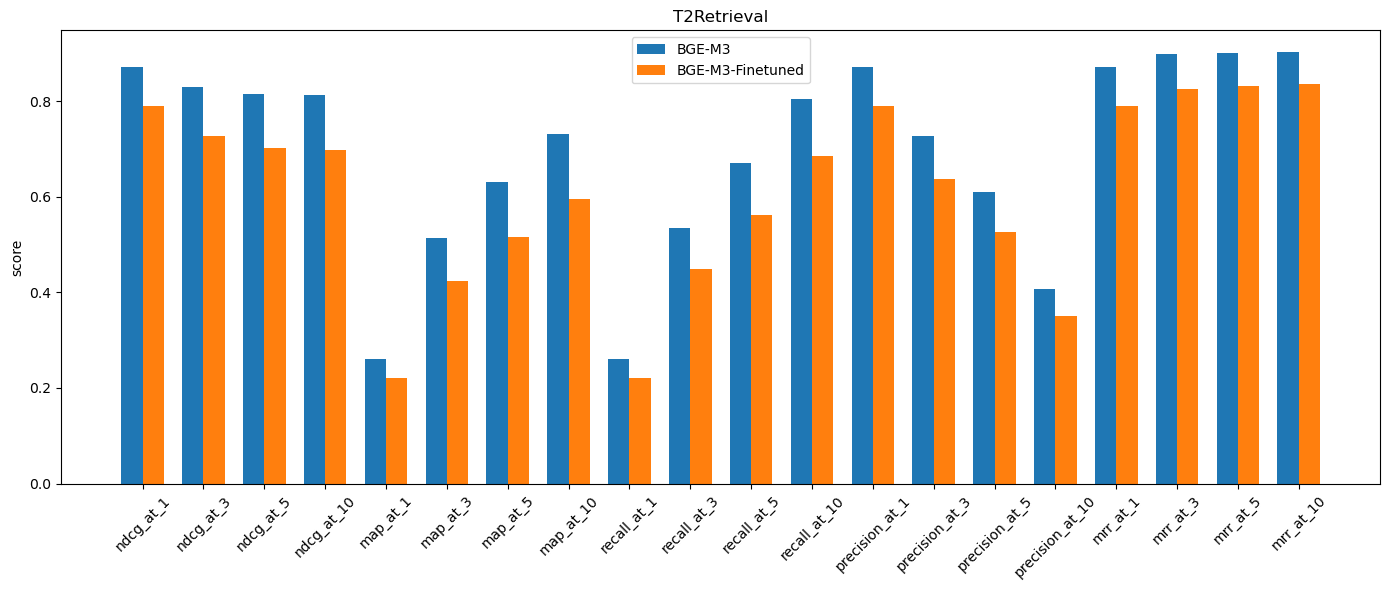

In [16]:
# 构建DataFrame
df = pd.DataFrame({
    'index': metrics,
    'BGE-M3': [scores_m3[m] for m in metrics],
    'BGE-M3-Finetuned': [scores_reranker[m] for m in metrics]
})

# 可视化
plt.figure(figsize=(14, 6))
bar_width = 0.35
x = range(len(metrics))

plt.bar(x, df['BGE-M3'], width=bar_width, label='BGE-M3')
plt.bar([i + bar_width for i in x], df['BGE-M3-Finetuned'], width=bar_width, label='BGE-M3-Finetuned')

plt.xticks([i + bar_width / 2 for i in x], df['index'], rotation=45)
plt.ylabel('score')
plt.title('T2Retrieval')
plt.legend()
plt.tight_layout()
plt.show()